In [1]:
from pymongo import MongoClient
from IPython.display import display, HTML, JSON
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
sci_col = MongoClient()["scimago"]["stage"]

In [8]:
#obtenemos todos los artículos por año para saber el ranking para el año específico
scores = []
for year in range(2013,2024):
    #year=2013
    print(year)
    current_score = {}
    current_score["year"] = year
    data = list(MongoClient()["openalex_udea"]["works"].find({"type":"article","publication_year":year,"primary_location.source.issn":{"$ne":None}}))
    score=[]
    for paper in data:
        issns = paper["primary_location"]["source"]["issn"]
        for issn in issns:
            issn = issn.replace("-","") ## scimago issn is not splitted by -
            rec = sci_col.find_one({"Issn":issn})
            if rec is not None:
                if not np.isnan(rec['SJR']):
                    score.append(rec['SJR'])
                else:
                    print(rec)
    current_score["score"] = score
    current_score["data_len"] = len(data)
    current_score["score_len"] = len(score)
    scores.append(current_score)

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [9]:
# 2013 = 337 / 1425
# 2014 = 252 / 1366
# 2015 = 318 / 1513
# 2016 = 237 / 1573
# 2017 = 322 / 1720
# 2018 = 282 / 1781
# 2019 = 320 / 1886
# 2020 = 389 / 2163
# 2021 = 370 / 2176
# 2022 = 465 / 2240
# 2023 = 496 / 2011

for i in scores:
    data = np.array(i["score"])
    nans = np.count_nonzero(np.isnan(data))
    print(f"{i['year']} = {nans} / {len(data)}")


2013 = 0 / 1421
2014 = 0 / 1356
2015 = 0 / 1509
2016 = 0 / 1568
2017 = 0 / 1712
2018 = 0 / 1777
2019 = 0 / 1875
2020 = 0 / 2154
2021 = 0 / 2168
2022 = 0 / 2221
2023 = 0 / 2001


In [10]:
for score in scores:
    print(f"year = {score['year']}")
    print(f"min  = {np.min(score['score'])}")
    print(f"max  = {np.max(score['score'])}")
    print("-"*10)
    

year = 2013
min  = 0.1
max  = 9.151
----------
year = 2014
min  = 0.1
max  = 19.69
----------
year = 2015
min  = 0.1
max  = 12.387
----------
year = 2016
min  = 0.1
max  = 14.796
----------
year = 2017
min  = 0.1
max  = 14.796
----------
year = 2018
min  = 0.1
max  = 14.796
----------
year = 2019
min  = 0.1
max  = 14.796
----------
year = 2020
min  = 0.1
max  = 14.618
----------
year = 2021
min  = 0.1
max  = 28.254
----------
year = 2022
min  = 0.1
max  = 28.254
----------
year = 2023
min  = 0.1
max  = 28.254
----------


In [11]:
for i in range(len(scores)):
    x = np.array(scores[i]["score"])
    scores[i]["score"] = x[~np.isnan(x)]
 

In [12]:
thold=200
years = []
payload = {}
#payload["papers"]=[]
payload[f" 0  <= JSR < 5 "]=[]
payload[f" 5  <= JSR < 10 "]=[]
payload[f" 10 <= JSR < 15 "]=[]
payload[f" 15  <= JSR < 20 "]=[]
payload[f" JSR >= 20 "]=[]



for score in scores:
    years.append(str(score["year"]))
    #payload["papers"].append(score["data_len"])
    counter = {}
    counter[f" 0  <= JSR < 5 "]=0
    counter[f" 5  <= JSR < 10 "]=0
    counter[f" 10 <= JSR < 15 "]=0
    counter[f" 15  <= JSR < 20 "]=0
    counter[f" JSR >= 20 "]=0

    for i in score['score']:
        if i>=0 and i < 5:
            counter[f" 0  <= JSR < 5 "] += 1
        if i>=5 and i < 10:
            counter[f" 5  <= JSR < 10 "] += 1
        if i>=10 and i < 15:
            counter[f" 10 <= JSR < 15 "] += 1
        if i>=15 and i < 20:
            counter[f" 15  <= JSR < 20 "] += 1
        if i>=20:
            counter[f" JSR >= 20 "] += 1
            
    payload[f" 0  <= JSR < 5 "].append(counter[f" 0  <= JSR < 5 "])
    payload[f" 5  <= JSR < 10 "].append(counter[f" 5  <= JSR < 10 "])
    payload[f" 10 <= JSR < 15 "].append(counter[f" 10 <= JSR < 15 "])
    payload[f" 15  <= JSR < 20 "].append(counter[f" 15  <= JSR < 20 "])
    payload[f" JSR >= 20 "]=[counter[f" JSR >= 20 "]]
payload

{' 0  <= JSR < 5 ': [1389,
  1332,
  1472,
  1525,
  1670,
  1727,
  1842,
  2072,
  2094,
  2128,
  1895],
 ' 5  <= JSR < 10 ': [32, 20, 31, 35, 40, 46, 27, 70, 58, 83, 92],
 ' 10 <= JSR < 15 ': [0, 2, 6, 8, 2, 4, 6, 12, 12, 8, 8],
 ' 15  <= JSR < 20 ': [0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2],
 ' JSR >= 20 ': [4]}

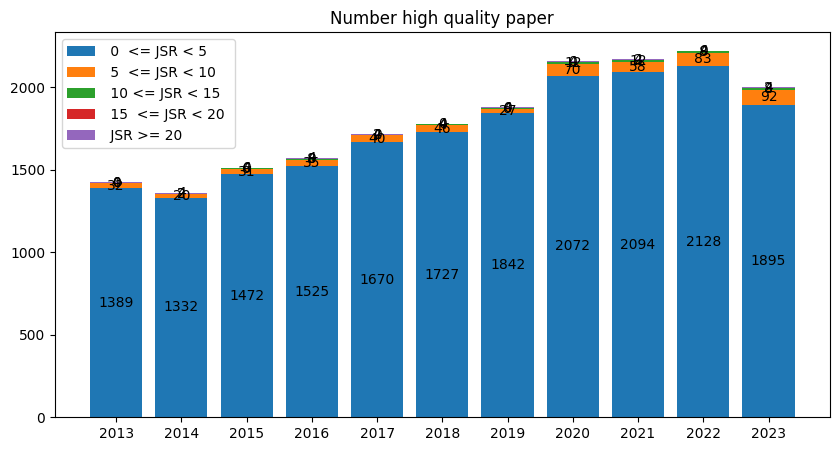

In [13]:

width = 0.8  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(11)

for title, count in payload.items():
    p = ax.bar(years, count, width, label=title, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number high quality paper')
ax.legend()

plt.show()

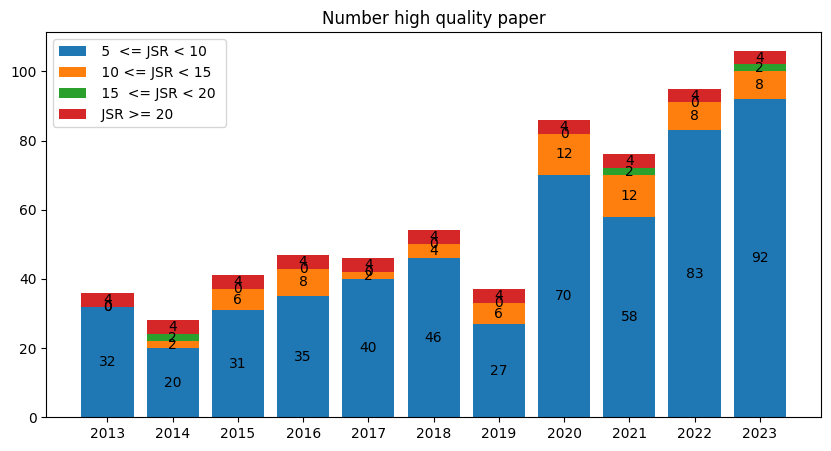

In [14]:
del payload[f" 0  <= JSR < 5 "]
width = 0.8  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(11)

for title, count in payload.items():
    p = ax.bar(years, count, width, label=title, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number high quality paper')
ax.legend()

plt.show()